# Predicting the solubilities of organic compounds

## 3. Building Machine Learning Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, SelectFromModel

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv("Data/df_final.csv")
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES,Mol,SpAbs_A,SpDiam_A,VR1_A,nAromAtom,nBridgehead,...,n5Ring,nHRing,n5HRing,nAHRing,n6AHRing,nFRing,nFHRing,nFARing,nRot,GhoseFilter
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011F0D9...,5.818626,4.148627,11.637367,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011F0D9...,4.000000,4.000000,8.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011F0D9...,6.000000,4.000000,11.530010,0,0,...,0,0,0,0,0,0,0,0,1,0
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011F0D9...,5.226252,3.695518,8.629874,0,0,...,0,0,0,0,0,0,0,0,1,0
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,<rdkit.Chem.rdchem.Mol object at 0x0000011F0D9...,7.211103,4.605551,17.881697,0,0,...,0,0,0,0,0,0,0,0,1,0


### 3.1 Declaring features and targets

In [3]:
y = df['measured log(solubility:mol/L)']
x = df.iloc[:,5:]

In [4]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y, test_size=0.20, random_state=420)

### 3.2 Multiple Linear Regression

In [38]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression()

In [39]:
print("r2 score for train:", reg.score(X_train, Y_train))
print("r2 score for test:", reg.score(X_test, Y_test))

r2 score for train: 0.9325247724039667
r2 score for test: 0.8815489244980775


Since multiple linear regression is penalized for utilizing too many features, we can conduct a small experiment to reduce the number of descriptors, keeping only those that are essential for explaining solubility. Thus, we are determining the number of features that gives the highest test accuracy for the model.

In [ ]:
def feature_optimization(x, y):
    train_acc = []
    test_acc = []

    highest_acc = 0
    n_desc_highest_acc = 0

    for i in range(x.shape[1]):
        # Initialize the model
        model = LinearRegression()

        # Perform Recursive Feature Elimination
        rfe = RFE(estimator=model, n_features_to_select=i + 1)
        X_new = rfe.fit_transform(x, y)

        # Split data and train the model
        x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)
        model.fit(x_train, y_train)

        # Calculate train and test accuracy
        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        
        # Find best test accuracy and number of features
        if test_score > highest_acc:
            highest_acc = test_score
            n_desc_highest_acc = i + 1

        # Saving accuracy as a %
        train_acc.append(100 * train_score)
        test_acc.append(100 * test_score)

    return train_acc, test_acc, highest_acc, n_desc_highest_acc 

#### Run the experiment and plot the results

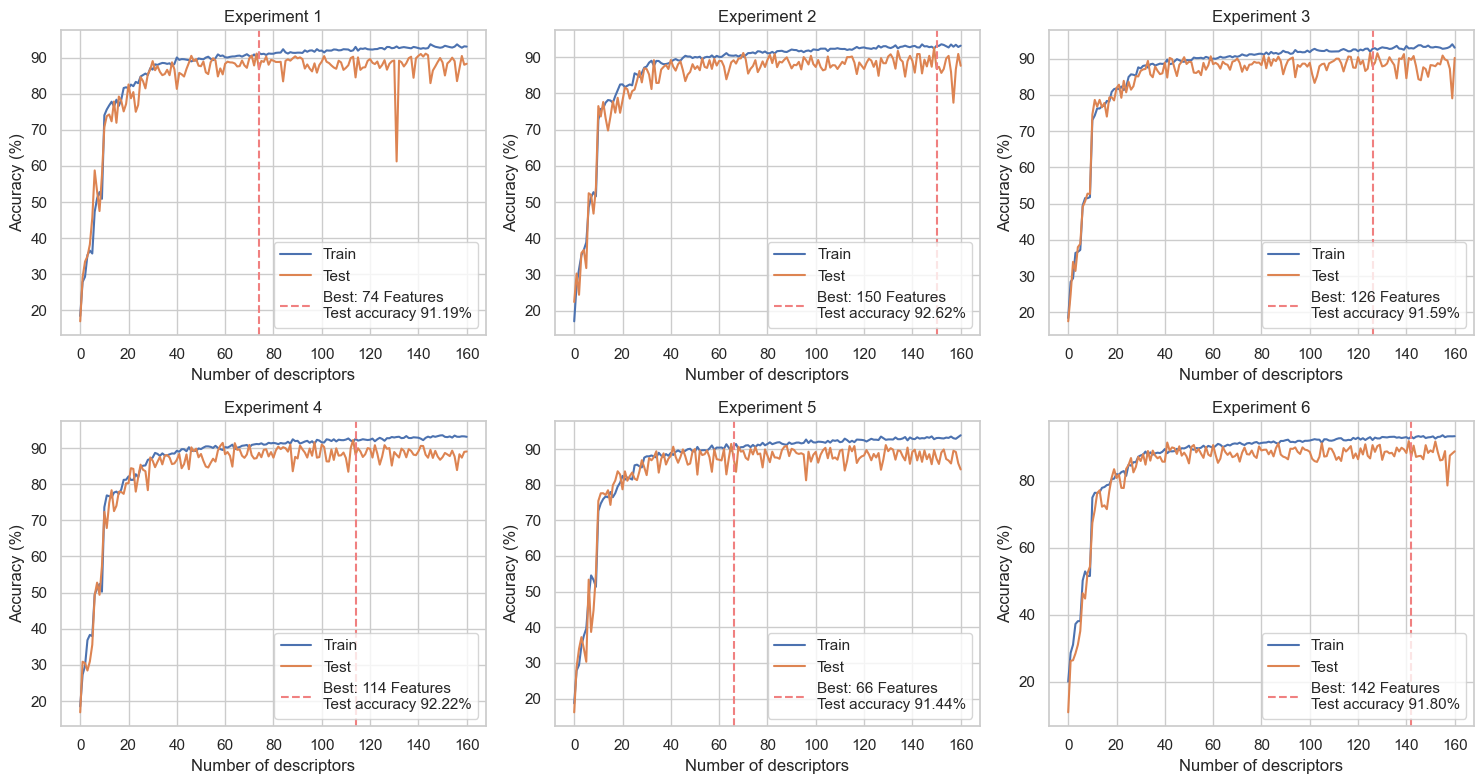

In [85]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax = ax.flatten()

for i in range(6):
    train_acc, test_acc, highest_acc, n_desc_highest_acc = feature_optimization(x, y)
    ax[i].plot(train_acc, label='Train')
    ax[i].plot(test_acc, label='Test')
    ax[i].axvline(n_desc_highest_acc, color='lightcoral', linestyle='--', label=f'Best: {n_desc_highest_acc} Features \nTest accuracy {highest_acc:.2%}')
    ax[i].set_xlabel('Number of descriptors')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_title(f'Experiment {i+1}')
    ax[i].legend(loc='lower right')

plt.tight_layout()
plt.show()

It’s important to note that this process is highly sensitive to the randomization of the data. Running the experiment multiple times without fixing the random state will result in different optimal number of features, typically within a range of 40 to 140 features. When the number of features is below 40, the model struggles to achieve an accuracy above 90%. On the other hand, with more than 100 features, the model likely begins to overfit, as many of the features lack predictive power and contribute to noise rather than useful information.

### 3.3 Random Forest Regressor

In [6]:
rf = RandomForestRegressor(random_state=420)
rf.fit(X_train, Y_train)

RandomForestRegressor(random_state=420)

In [7]:
print("r2 score for train:", rf.score(X_train, Y_train))
print("r2 score for test:", rf.score(X_test, Y_test))

r2 score for train: 0.9832081823690556
r2 score for test: 0.8800452734434099


#### Testing different number of estimators

In [8]:
scores = []

for n in range(1, 101, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train, Y_train)
    scores.append(rf.score(X_test, Y_test))

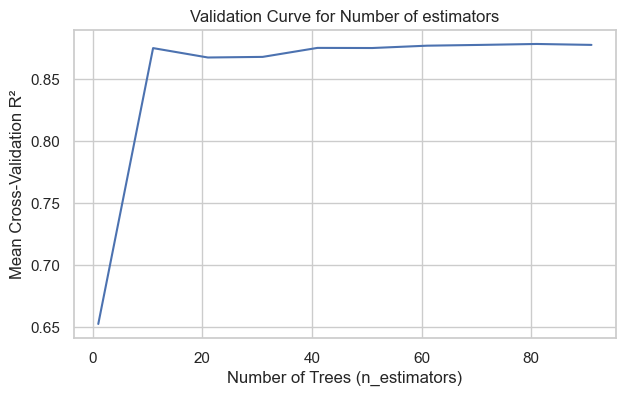

In [9]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 101, 10), scores)
plt.title('Validation Curve for Number of estimators')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Cross-Validation R²')
plt.show()

In [64]:
rf = RandomForestRegressor(n_estimators=100, random_state=420)
rf.fit(X_train, Y_train)

# SelectFromModel to select important features with median as a threshold
selector = SelectFromModel(rf, threshold='median') 
selector.fit(X_train, Y_train)

# Get the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Training a new model with selected features
rf_selected = RandomForestRegressor(n_estimators=100, random_state=420)
rf_selected.fit(X_train_selected, Y_train)

# Evaluate the model
print("Original Features Shape:", X_train.shape)
print("Selected Features Shape:", X_train_selected.shape)
print("Original Model Score:", rf.score(X_test, Y_test))
print("Model Score with Selected Features:", rf_selected.score(X_test_selected, Y_test))

Original Features Shape: (915, 161)
Selected Features Shape: (915, 81)
Original Model Score: 0.8800452734434099
Model Score with Selected Features: 0.8783408828586197


In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10, 15, 20],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=20, cv=5, n_jobs=-1)
random_search.fit(X_train_selected, Y_train)

# Best parameters
print(random_search.best_params_)

{'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


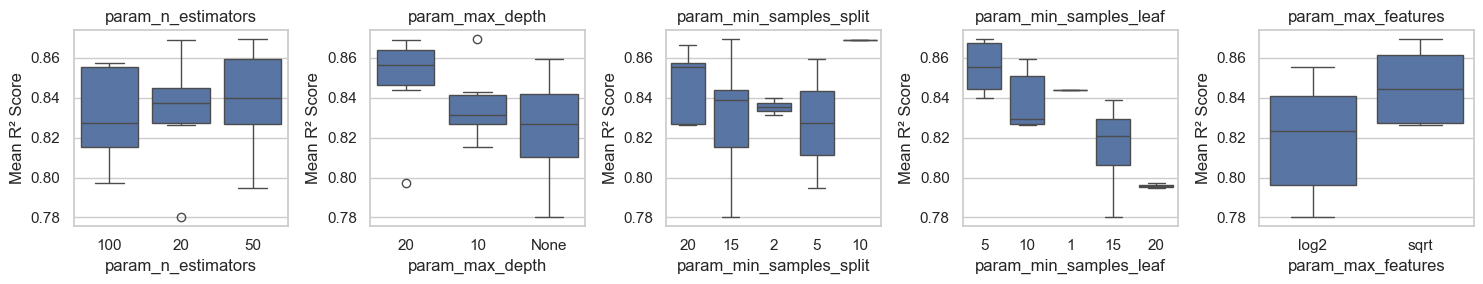

In [54]:
results_rf = pd.DataFrame(random_search.cv_results_)

hyperparameter = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features']

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
ax = ax.flatten()

for i, param in enumerate(hyperparameter):
    sns.boxplot(ax=ax[i], x=results_rf[param].astype(str), y=results_rf['mean_test_score'])
    ax[i].set_xlabel(param)
    ax[i].set_ylabel("Mean R² Score")
    ax[i].set_title(param)

plt.tight_layout()
plt.show()

In [55]:
rf = RandomForestRegressor(n_estimators=50, min_samples_split=5, min_samples_leaf=5, max_features='sqrt', max_depth=10, bootstrap=False)
rf.fit(X_train_selected, Y_train)

print("r2 score for train:", rf.score(X_train_selected, Y_train))
print("r2 score for test:", rf.score(X_test_selected, Y_test))

r2 score for train: 0.9692176952837238
r2 score for test: 0.8730375549653234


#### Cross-Validation

In [61]:
val = cross_val_score(rf, X_train_selected, Y_train, scoring='r2', cv=10)
val

array([0.85714904, 0.9264997 , 0.8975847 , 0.87071348, 0.90032345,
       0.87362676, 0.8281529 , 0.8889239 , 0.86941407, 0.85914388])

In [62]:
val.mean()

0.8771531882598159

#### Results

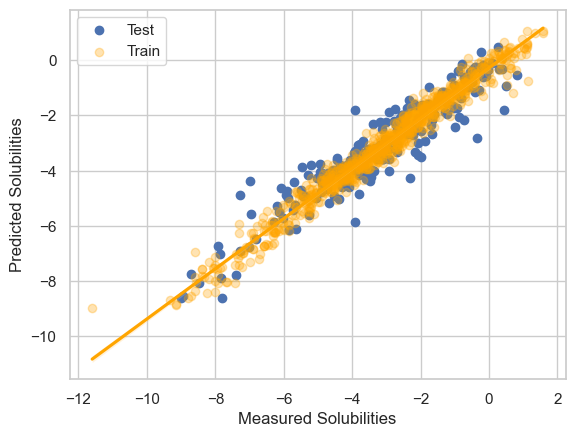

In [63]:
plt.scatter(Y_test, rf.predict(X_test_selected), label='Test')
sns.regplot(
    x=Y_train, 
    y=rf.predict(X_train_selected), 
    color='orange', 
    scatter_kws={'alpha': 0.3},
    label='Train')
plt.xlabel('Measured Solubilities')
plt.ylabel('Predicted Solubilities')
plt.legend()
plt.show()

### PCA

In [50]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA()
pca.fit(x_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)

#### Finding the minimum number of principal components required to preserve the 95% and 99% of the data’s variance

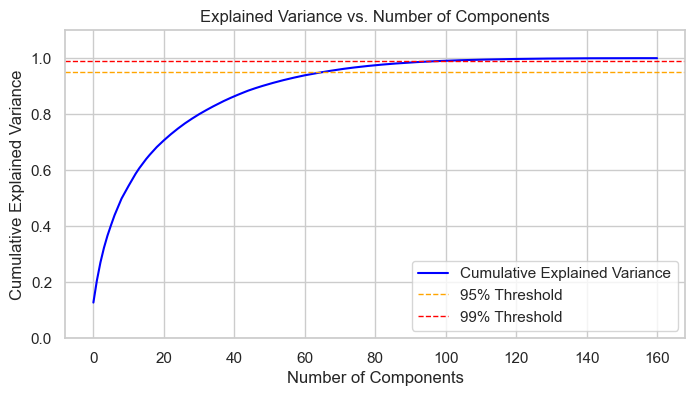

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(cumsum, color='blue', label='Cumulative Explained Variance')
plt.ylim(0, 1.1)
plt.axhline(y=0.95, color='orange', linestyle='--', linewidth=1, label='95% Threshold')
plt.axhline(y=0.99, color='red', linestyle='--', linewidth=1, label='99% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend()
plt.show()

In [53]:
def custom_pca(x, y, cumsum, df):
    for threshold in [99, 95]:
        d = np.argmax(cumsum >= threshold / 100) + 1
        pca = PCA(n_components=d)
        pc = pca.fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(pc, y, test_size=0.20, random_state=420)
        
        # Linear Regression
        lr_pca = LinearRegression()
        lr_pca.fit(x_train, y_train)
        
        # Random Forest
        rf_pca = RandomForestRegressor()
        rf_pca.fit(x_train, y_train)
        
        key = str(threshold) + '%' 
        df[key] = [
            lr_pca.score(x_train, y_train), 
            lr_pca.score(x_test, y_test), 
            rf_pca.score(x_train, y_train), 
            rf_pca.score(x_test, y_test)]
    return df

Combining everything into a table to provide a clearer overview.

In [54]:
summary = {
    'Models': ['Linear Regression train', 'Linear Regression test', 'Random Forest train', 'Random Forest test'],
    '100%': [reg.score(X_train, Y_train),  reg.score(X_test, Y_test), rf.score(X_train, Y_train), rf.score(X_test, Y_test)]}
summary_df = pd.DataFrame(data=summary)
summary_df = custom_pca(x_scaled, y, cumsum, summary_df)

In [55]:
summary_df

,Models,100%,99%,95%
0,Linear Regression train,-297562.963005,0.906008,0.893574
1,Linear Regression test,-55955.990798,0.854632,0.817209
2,Random Forest train,0.852829,0.974017,0.976963
3,Random Forest test,-0.171749,0.807584,0.814677
